In [331]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg as sLA

from IPython.display import Image
from IPython.display import display, Latex

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

from matplotlib import style
# style.use('ggplot')

In [332]:
from scipy import linalg as sLA
from scipy.special import hermite, factorial
from scipy.integrate import quad
from scipy.stats import chi2, chisquare
from scipy import interpolate
from tqdm import tqdm

In [333]:
#Вычисление Фиделити для векторов чистых состояний
def Fidelity_pure(vec0, vec1):
    return np.abs(np.dot(vec0, vec1.conjugate())) ** 2

# Функция для отрисовки 3-D barchart
def plot_matrix(m, title = 'Входное состояние'):
    
    style.use('ggplot')

    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(111, projection='3d')
    
    xi = np.reshape(list(np.arange(m.shape[0]))*m.shape[1], (-1))
    yi = np.reshape(np.reshape((list(np.arange(m.shape[1]))*m.shape[0]), (m.shape[1], m.shape[0])).T, (-1))
    z0 = np.zeros(m.shape[0]*m.shape[1])
    
    dx = np.ones(m.shape[0]*m.shape[1])
    dy = np.ones(m.shape[1]*m.shape[0])
    dz = np.reshape(m, (-1))
    
    ax1.bar3d(xi, yi, z0, dx, dy, dz, shade=True)


    ax1.set_xlabel('Колличество фотонов во втором канале n2')
    ax1.set_ylabel('Колличество фотонов в первом канале n1')
    ax1.set_zlabel('Вероятность p1p2')
    ax1.set_title(title)

    plt.show()

# Пункт 1:
### Зададим состояниее согласно 3-му варианту и определим для него фоковское пространство, достаточное для представленияя с точностью $10^{-6}$

Вариант 3:

Рассматриваемое состояние:

$\phi ~ | \alpha \rangle + |1 \rangle$, где $\alpha = 0.9i$ =>

$\phi =  (|1 \rangle + e^{\frac{-|\alpha|^2}{2}} \sum_{n=0}^{n_{max}} \frac{\alpha^{n}}{\sqrt{n!}} |n\rangle) /  norm$, где $n = 0.9i$

In [334]:
# Создаёт когерентное состояние
def get_rho_coherent(N, d, alpha = 0.9*1j):
    n = np.arange(N)
    fact_n = np.array([np.math.factorial(x) for x in n]).astype(float)
    state = np.exp((-np.abs(alpha) ** 2) / 2) * (alpha ** n) / np.sqrt(fact_n)
    rho = np.outer(state,state.conjugate())
    
    rho_full = np.zeros((d,d))
    rho_full[:N,:N] = rho
    return rho_full, state


def get_coherent_probs(n, alpha = 0.9*1j):
    return np.exp((-np.abs(alpha) ** 2)) * (np.abs(alpha) ** (2*n)) / float(np.math.factorial(n))

def get_coherent_coefs(n, alpha = 0.9*1j):
    return np.exp((-np.abs(alpha) ** 2) / 2) * (alpha ** (2*n)) / np.sqrt(float(np.math.factorial(n)))
    
# Расчитывает ошибку ограничения размерности рассматриваемой системы
def restrictions_err(N, func = get_coherent_probs):
    return 1 - sum([func(i) for i in range(N)])

def get_my_state(N, d):
    _, state = get_rho_coherent(N, d, alpha = 0.9*1j)
    state1 = np.zeros(len(state))
    state1[1] = 1
    state += state1
    norm_coef = np.sqrt(state@state.conj())
    
    state = state/norm_coef
    rho = np.outer(state,state.conjugate())
    
    rho_full = np.zeros((d,d))
    rho_full[:N,:N] = rho
    return rho, state

Заданное состояние является суперпозицией фоковского и когерентного. При этом фоковское cостояние $|1 \rangle$ представляется точно в рассматриваемом фоковском пространнстве $n>=1$.
Будем следить только за точностью представления когерентного состояния.

Найдём размерность достаточную для представления когерентного состояния с точностью $10^{-6}$

In [335]:
print('Ошибка в распределении за счёт сокращения размерности до 8:', restrictions_err(8))
print('Ошибка в распределении за счёт сокращения размерности до 9:', restrictions_err(9))

Ошибка в распределении за счёт сокращения размерности до 8: 2.244554789920805e-06
Ошибка в распределении за счёт сокращения размерности до 9: 2.0008311862884653e-07


Достаточно рассмотреть фоковское пространство размерностью 9

In [336]:
N = 9
# Получим заданное состояние
my_rho, my_state = get_my_state(N, N)

# Определим массив коэфициентов cn при соответствующих состояниях |n>
cn_list = my_state

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part



# Пункт 2:
#### Зададим состояние через разложение на полиномы Эрмита

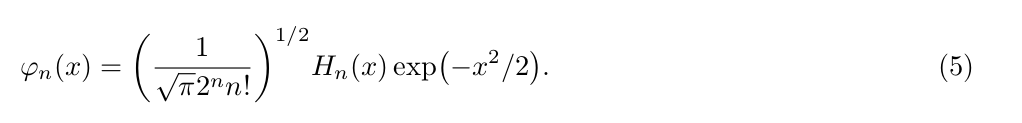

In [337]:
from IPython.display import Image
Image(filename='pics/Chebyshev_hermit_basis.png')

Также учтём зависимость от фазы

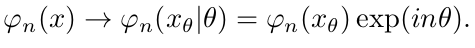

In [338]:
Image(filename='pics/psi_theta.png')

И окончательно получим состояние через найденные пункте 1 коэффициенты $c_n$

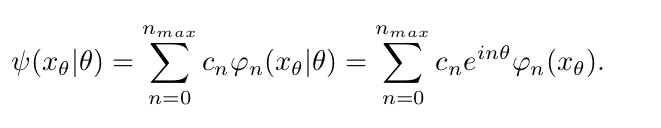

In [339]:
Image(filename='pics/state.png')

In [340]:
def phi_theta(n, x, theta):
    return (1/(np.pi**0.5*2**n*factorial(n)))**(1/2)*hermite(n)(x)*np.exp(-x**2/2)*np.exp(1j*n*theta)

def get_theor_state(cn_list, N, x, theta):
    return np.sum(np.array([cn_list[i]*phi_theta(i, x, theta) for i in range(N)]), axis = 0)
    
def get_probs(state):
    return abs(state)**2

# Более быстрая функция для вероятности. Понадобится при решении УП
def p_(phi_theta, psi):
    return abs(np.tensordot(psi, phi_theta, axes=1))**2

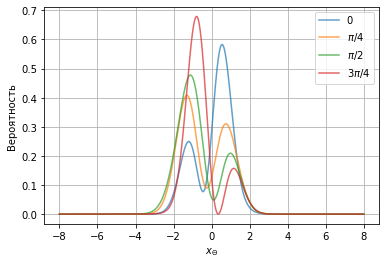

In [341]:
x_list = np.linspace(-8, 8, 1000)
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_label = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']

for theta, theta_label in zip(thetas, thetas_label):
    p_list = get_probs(get_theor_state(cn_list, N, x_list, theta))
    plt.plot(x_list, p_list, '-', alpha=0.7, label=theta_label)
plt.xlabel('$x_\Theta$')
plt.ylabel('Вероятность')
plt.legend()
plt.grid()
plt.show()

# Пункт 3:
#### Выполним симуляцию измерений для каждого значения $\theta$

In [342]:
def F(z, x_list, state):
    return np.trapz(get_probs(state)[x_list <= z], x_list[x_list <= z])

In [418]:
n = 10000
L = 10
inv_points = 100



x_list = np.linspace(-L, L, inv_points)

thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_label = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']

Func_list = []
x_rec_list = []

for theta in thetas:
    y = []
    state = get_theor_state(cn_list, N, x_list, theta)
    for x_inv in tqdm(x_list):
        y.append(F(x_inv, x_list, state))
                 
    # Восстановим функцию распределения
    F_inv = interpolate.interp1d(y, x_list, fill_value=(0, 1), bounds_error=False)
    Func_list.append(F_inv)
    
    # Из восстановленной ф-ии распределения сгенерируем 1000 случайных величин
    # Каждое соответствует измерению
    y_random = np.random.rand(n)
    x_reconstructed = F_inv(y_random)
    x_rec_list.append(x_reconstructed)
    

100%|██████████| 100/100 [00:00<00:00, 22651.10it/s]


#### Построим соответствующие распределения

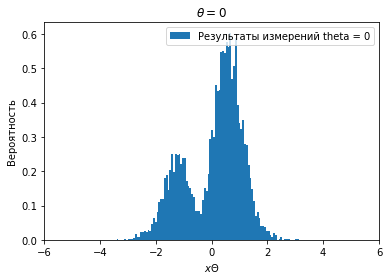

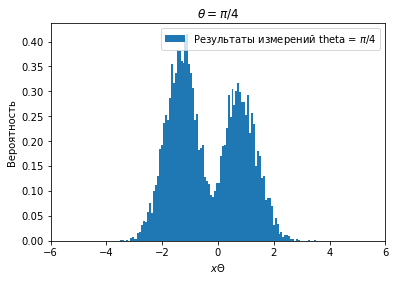

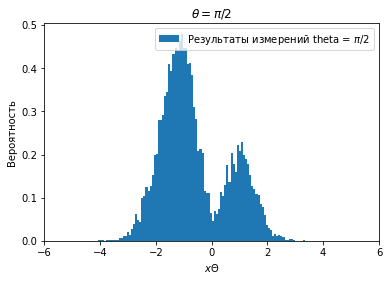

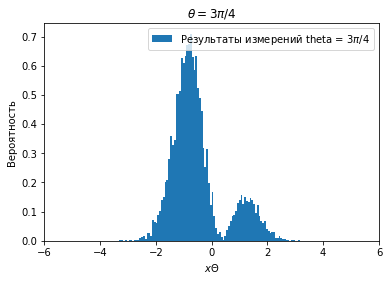

In [439]:
for x_rec, theta_label in zip(x_rec_list, thetas_label):   
    plt.hist(x_rec, bins=100, density=True, label=f'Результаты измерений theta = {theta_label}')
    plt.xlabel('$x \Theta$')
    plt.ylabel('Вероятность')
    plt.title(r'$\theta = $' + f'{theta_label}')
    plt.xlim(-6, 6)
    plt.legend()
    plt.show()

# Пункт 4:

#### Проведём реконструкцию состояния методом MLE

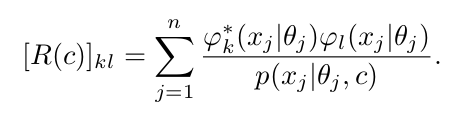

In [440]:
Image(filename='pics/R_matrix.png')

Создадим полный набор $(x_j, \theta_j)$

In [441]:
len(x_rec_list[0])

10000

In [442]:
# Полный набор измерений состоит из 4000 измерений по 4000 на каждую theta
x_rec_list = np.array(x_rec_list)

thetas_list = []
for theta in thetas:
    thetas_list.append([theta]*x_rec_list.shape[1])
    
thetas_list = np.array(thetas_list)


In [443]:
# Зададим функцию собирающую матрицу R(c)

# Заметим, что числители дробей в сумме выше не зависят от c. 
# Посчитаем их заранее, чтобы не пересчитывать на каждой итерации далее


def get_R_numerators(N = 9, thetas = thetas, x_rec_list = x_rec_list):
    psi_n_list = []
    for n in range(N):
        psi = []
        for theta, x in zip(thetas, x_rec_list):       
            psi.append(phi_theta(n, x, theta))
        psi = np.array(psi).flatten()
        psi_n_list.append(psi)
    
    numerators_list = np.reshape([psi1.conj()*psi2 for psi1 in psi_n_list for psi2 in  psi_n_list], (9,9,40000))                       
    return np.array(numerators_list).T

numerators_list = get_R_numerators()

In [444]:
def get_R(c, numerators_list):
    denumerators_list = []
    for theta, x in zip(thetas, x_rec_list):
        state = get_theor_state(c, N, x, theta)
        p = get_probs(state)
        denumerators_list.append(p)
        
    denumerators_list = np.array(denumerators_list).flatten()
    return np.sum(numerators_list/np.reshape(denumerators_list, (40000, 1, 1)), axis = 0).T
    
    

In [445]:
# Проверим работу ф-ии
c = np.random.randn(9)
c = c/np.sqrt(c**2)
R = get_R(c, numerators_list)
print(R)

[[ 3966157.0758365 +0.00000000e+00j  2221773.69465205-9.75814041e+03j
  -1662710.37858611-1.35582934e+02j -2049406.99241828-3.30639515e+03j
    956383.63121036+1.50200866e-12j  1883918.2426799 -1.65251579e+03j
   -621087.79406482+1.44902788e+03j -1830071.72584271-3.03996781e+02j
    346741.74580292+7.17825140e-12j]
 [ 2221773.69465205+9.75814041e+03j  1629197.66788104+0.00000000e+00j
   -419531.35544607-4.37951333e+03j  -933996.49785126+2.65344584e+03j
    113755.26984764-2.91765267e+03j   666282.65445414-4.76762921e-13j
   -226089.8614702 -4.47207310e+03j  -591557.08333061+6.76781317e+02j
    338393.71685556-6.97871636e+03j]
 [-1662710.37858611+1.35582934e+02j  -419531.35544607+4.37951333e+03j
   1620886.05829492+0.00000000e+00j  1091009.97720036-3.11745867e+03j
   -974411.69432036+2.22512636e+03j -1543867.6174598 +1.96413877e+03j
    471664.35526261-6.65898821e-13j  1555477.51261373+9.19117128e+02j
    -31793.21610213+7.88507409e+02j]
 [-2049406.99241828+3.30639515e+03j  -933996.4978

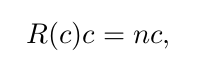

In [446]:
Image(filename='pics/iter_method.png')

In [447]:
%%time

eps = 1e-8
mu=0.5

# Зададим случайное чистое состояние в качестве начального приближения
c = np.random.randn(9)
c = c/np.sqrt(c**2)

for i in tqdm(range(1000)):
    c_prev = c
    c = (1-mu)*get_R(c_prev, numerators_list) @ c_prev/ 40000 + mu*c_prev
    print(np.sum(abs(c_prev - c)**2)**0.5)
    if np.sum(abs(c_prev - c)**2)**0.5 < eps:
        break
    
    


  0%|          | 2/1000 [00:00<02:38,  6.31it/s]

1.3392613512603122
0.5839684266684068


  0%|          | 4/1000 [00:00<02:11,  7.55it/s]

0.3370096772309127
0.18238091449453295


  1%|          | 6/1000 [00:00<02:04,  7.98it/s]

0.26713633319877683
0.14805919097183023


  1%|          | 8/1000 [00:01<02:04,  7.99it/s]

0.09842371133284664
0.182439748182179


  1%|          | 10/1000 [00:01<02:05,  7.89it/s]

0.09543400768370484
0.1149015683912305


  1%|          | 12/1000 [00:01<02:03,  7.99it/s]

0.0591885229230212
0.04151159799654674


  1%|▏         | 14/1000 [00:01<02:04,  7.94it/s]

0.03366210541129224
0.03131993717893971


  2%|▏         | 16/1000 [00:02<02:02,  8.04it/s]

0.017945059465970963
0.01324702910629359


  2%|▏         | 18/1000 [00:02<02:01,  8.08it/s]

0.01011114628455314
0.007988704234801936


  2%|▏         | 20/1000 [00:02<02:07,  7.71it/s]

0.006368320761042738
0.005026897583633328


  2%|▏         | 22/1000 [00:02<02:02,  8.00it/s]

0.003928936495003165
0.0030592428250811056


  2%|▏         | 24/1000 [00:03<01:57,  8.30it/s]

0.002388855730907893
0.0018837786076141112


  3%|▎         | 26/1000 [00:03<02:02,  7.94it/s]

0.001510902515863325
0.0012405065929397476


  3%|▎         | 28/1000 [00:03<02:11,  7.40it/s]

0.0010471051631410642
0.0009095886222049804


  3%|▎         | 30/1000 [00:03<02:22,  6.81it/s]

0.0008111606258973477
0.0007391137893235651


  3%|▎         | 32/1000 [00:04<02:08,  7.53it/s]

0.0006843463179509043
0.0006406599569854564


  3%|▎         | 34/1000 [00:04<02:03,  7.83it/s]

0.0006040041565442748
0.00057181417748466


  4%|▎         | 36/1000 [00:04<02:23,  6.70it/s]

0.0005425056053401282
0.0005151206275481929


  4%|▍         | 38/1000 [00:05<02:33,  6.26it/s]

0.0004890934963416789
0.0004640999723345301


  4%|▍         | 40/1000 [00:05<02:47,  5.72it/s]

0.0004399625336565169
0.0004165914073692889


  4%|▍         | 42/1000 [00:05<02:41,  5.92it/s]

0.00039394817774926277
0.00037202345944364884


  4%|▍         | 44/1000 [00:06<02:44,  5.81it/s]

0.00035082326657967397
0.0003303607314350727


  5%|▍         | 46/1000 [00:06<02:43,  5.83it/s]

0.0003106511051294622
0.0002917087721733806


  5%|▍         | 48/1000 [00:06<02:20,  6.75it/s]

0.0002735455058016459
0.0002561694949887793


  5%|▌         | 50/1000 [00:07<02:01,  7.83it/s]

0.00023958485896881742
0.00022379147645321703


  5%|▌         | 52/1000 [00:07<02:14,  7.03it/s]

0.00020878502308113676
0.00019455714972350837


  5%|▌         | 54/1000 [00:07<02:16,  6.95it/s]

0.00018109575710412268
0.00016838533555627868


  6%|▌         | 56/1000 [00:07<02:08,  7.34it/s]

0.00015640734669697498
0.00014514062880691063


  6%|▌         | 58/1000 [00:08<01:57,  7.99it/s]

0.00013456181115593732
0.00012464572518072647


  6%|▌         | 60/1000 [00:08<01:49,  8.55it/s]

0.00011536580269914411
0.00010669445340677399


  6%|▌         | 62/1000 [00:08<01:45,  8.87it/s]

9.860341580448243e-05
9.106407745064808e-05


  6%|▋         | 64/1000 [00:08<01:45,  8.85it/s]

8.404776199708643e-05
7.752598183230429e-05


  7%|▋         | 66/1000 [00:09<01:47,  8.71it/s]

7.147065630418051e-05
6.585429642377798e-05


  7%|▋         | 68/1000 [00:09<01:43,  9.03it/s]

6.065015766997428e-05
5.583236303673119e-05


  7%|▋         | 70/1000 [00:09<01:41,  9.18it/s]

5.137599881265108e-05
4.725718578181717e-05


  7%|▋         | 72/1000 [00:09<01:41,  9.12it/s]

4.345312861039173e-05
3.994214616226722e-05


  7%|▋         | 74/1000 [00:09<01:40,  9.18it/s]

3.67036853903093e-05
3.37183213006846e-05


  8%|▊         | 76/1000 [00:10<01:39,  9.29it/s]

3.0967745301789614e-05
2.843474404266258e-05


  8%|▊         | 78/1000 [00:10<01:42,  9.03it/s]

2.6103170629527106e-05
2.3957909892358718e-05


  8%|▊         | 80/1000 [00:10<01:45,  8.73it/s]

2.1984839163020225e-05
2.0170785827063582e-05


  8%|▊         | 82/1000 [00:10<01:43,  8.87it/s]

1.8503482726150396e-05
1.6971522318698855e-05


  8%|▊         | 84/1000 [00:11<01:46,  8.64it/s]

1.5564310354038874e-05
1.4272019679429132e-05


  9%|▊         | 86/1000 [00:11<01:45,  8.66it/s]

1.3085544680384045e-05
1.1996456750380978e-05


  9%|▉         | 88/1000 [00:11<01:42,  8.87it/s]

1.0996961097148186e-05
1.0079855115780495e-05


  9%|▉         | 90/1000 [00:11<01:40,  9.06it/s]

9.238488494816477e-06
8.466725167094039e-06


  9%|▉         | 92/1000 [00:12<02:01,  7.45it/s]

7.75890717255176e-06
7.1098204636658106e-06


  9%|▉         | 94/1000 [00:12<02:11,  6.90it/s]

6.514662654153972e-06
5.969012688336116e-06


 10%|▉         | 95/1000 [00:12<02:24,  6.28it/s]

5.468802389919352e-06


 10%|▉         | 96/1000 [00:12<02:36,  5.78it/s]

5.010289834683563e-06


 10%|▉         | 98/1000 [00:13<02:32,  5.91it/s]

4.59003448124646e-06
4.2048739863148655e-06


 10%|█         | 100/1000 [00:13<02:06,  7.10it/s]

3.8519026261023685e-06
3.5284512423083997e-06


 10%|█         | 102/1000 [00:13<01:51,  8.04it/s]

3.2320686300456905e-06
2.960504284749287e-06


 10%|█         | 104/1000 [00:13<02:08,  7.00it/s]

2.711692426564708e-06
2.4837372220423925e-06


 11%|█         | 106/1000 [00:14<02:35,  5.76it/s]

2.274899125828671e-06
2.083582267689768e-06


 11%|█         | 108/1000 [00:14<02:07,  7.02it/s]

1.9083228135322116e-06
1.7477782323649262e-06


 11%|█         | 110/1000 [00:14<01:50,  8.08it/s]

1.6007174047729792e-06
1.4660115120383677e-06


 11%|█         | 112/1000 [00:14<01:43,  8.55it/s]

1.3426256484420982e-06
1.229611103036657e-06


 11%|█▏        | 114/1000 [00:15<01:41,  8.76it/s]

1.1260982603132285e-06
1.0312900727902031e-06


 12%|█▏        | 116/1000 [00:15<01:39,  8.89it/s]

9.44456061404032e-07
8.649268028453776e-07


 12%|█▏        | 118/1000 [00:15<02:05,  7.05it/s]

7.920888658566772e-07
7.25380161063945e-07


 12%|█▏        | 120/1000 [00:15<01:52,  7.81it/s]

6.642856716244343e-07
6.083335344621159e-07


 12%|█▏        | 122/1000 [00:16<01:47,  8.19it/s]

5.570914439178191e-07
5.101633519965454e-07


 12%|█▏        | 124/1000 [00:16<01:42,  8.53it/s]

4.6718644113162807e-07
4.278283476264504e-07


 13%|█▎        | 126/1000 [00:16<01:43,  8.44it/s]

3.917846150095583e-07
3.587763590029797e-07


 13%|█▎        | 128/1000 [00:16<01:42,  8.54it/s]

3.2854812643442e-07
3.008659322761591e-07


 13%|█▎        | 130/1000 [00:17<01:42,  8.45it/s]

2.7551546035341864e-07
2.523004139166419e-07


 13%|█▎        | 132/1000 [00:17<01:50,  7.85it/s]

2.3104100402599946e-07
2.1157256409061e-07


 13%|█▎        | 134/1000 [00:17<01:42,  8.44it/s]

1.9374428032066992e-07
1.7741802826816553e-07


 14%|█▎        | 136/1000 [00:17<01:37,  8.83it/s]

1.6246730688406027e-07
1.487762617536399e-07


 14%|█▍        | 138/1000 [00:18<01:38,  8.76it/s]

1.362387902537592e-07
1.247577216579775e-07


 14%|█▍        | 140/1000 [00:18<01:36,  8.94it/s]

1.1424406609036541e-07
1.0461632647386502e-07


 14%|█▍        | 142/1000 [00:18<01:39,  8.65it/s]

9.579986821390913e-08
8.772634180693445e-08


 14%|█▍        | 144/1000 [00:18<01:59,  7.18it/s]

8.033315404087847e-08
7.356298345034873e-08


 15%|█▍        | 146/1000 [00:19<01:51,  7.68it/s]

6.736333670366035e-08
6.168614211783155e-08


 15%|█▍        | 148/1000 [00:19<01:44,  8.16it/s]

5.6487377424252194e-08
5.172672881410777e-08


 15%|█▌        | 150/1000 [00:19<01:40,  8.48it/s]

4.736727873326631e-08
4.337521981058808e-08


 15%|█▌        | 152/1000 [00:19<01:35,  8.84it/s]

3.971959297415915e-08
3.6372047535795794e-08


 15%|█▌        | 154/1000 [00:20<01:32,  9.18it/s]

3.330662157161886e-08
3.0499540594317876e-08


 16%|█▌        | 156/1000 [00:20<01:35,  8.83it/s]

2.7929033405012154e-08
2.557516325835653e-08


 16%|█▌        | 158/1000 [00:20<01:35,  8.85it/s]

2.3419673360093504e-08
2.1445845373443323e-08


 16%|█▌        | 160/1000 [00:20<01:34,  8.86it/s]

1.963836968724419e-08
1.7983226860103746e-08


 16%|█▌        | 162/1000 [00:20<01:35,  8.74it/s]

1.6467578840452858e-08
1.5079669445087075e-08


 16%|█▋        | 164/1000 [00:21<01:33,  8.99it/s]

1.3808733216191697e-08
1.2644911900794881e-08


 17%|█▋        | 166/1000 [00:21<01:29,  9.29it/s]

1.1579178036095076e-08
1.0603264977374495e-08


 17%|█▋        | 166/1000 [00:21<01:48,  7.71it/s]

9.709602725660643e-09
CPU times: user 16.7 s, sys: 4.81 s, total: 21.5 s
Wall time: 21.5 s


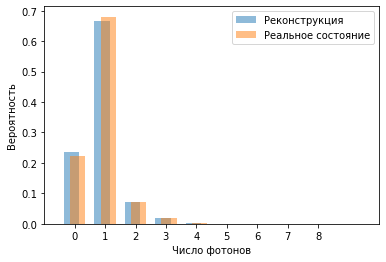

In [448]:
n_list = np.arange(9)

plt.bar(n_list-0.1, abs(c)**2, alpha=0.5, width=0.5, label='Реконструкция')
plt.bar(n_list+0.1, abs(cn_list)**2, alpha=0.5, width=0.5, label='Реальное состояние')
plt.xticks(n_list)
plt.xlim(-1, 10)
plt.xlabel('Число фотонов')
plt.ylabel('Вероятность')
plt.legend()
plt.show()

In [449]:
# Рассчитаем Fidelity между реконструкцией и реальным состоянием
Fidelity_pure(c, cn_list)

0.9989853802692745

Состояния совпадаяют с высокой точностью

# Пункт 4:

#### Построим распределения для различных $\theta$

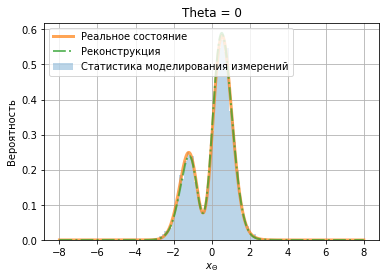

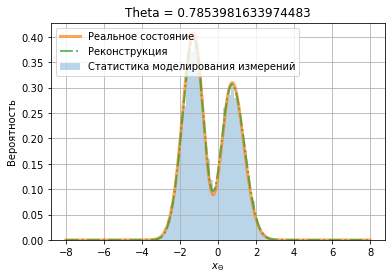

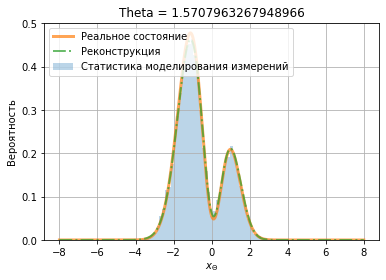

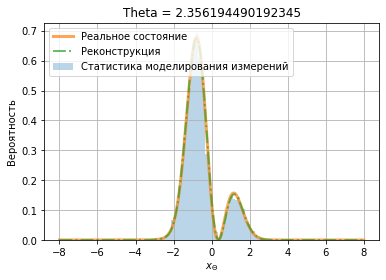

In [450]:
x_list = np.linspace(-8, 8, 1000)
thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]
thetas_label = ['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$']


for x, theta, theta_label in zip(x_rec_list, thetas, thetas_label):
    
    plt.hist(x, density = True, bins = 50, alpha = 0.3, label = 'Статистика моделирования измерений')
    
    p_list = get_probs(get_theor_state(cn_list, N, x_list, theta))
    plt.plot(x_list, p_list, '-', linewidth = 3, alpha=0.7, label='Реальное состояние')
    
    p_list = get_probs(get_theor_state(c, N, x_list, theta))
    plt.plot(x_list, p_list, '-.', linewidth = 2, alpha=0.7, label='Реконструкция')
    
    plt.title(f'Theta = {theta}')
    plt.xlabel('$x_\Theta$')
    plt.ylabel('Вероятность')
    plt.legend(loc='upper left')
    plt.grid()
    
    plt.show()
    
    

# Пункт 6:

#### Вычислим p-value для всех $\theta$

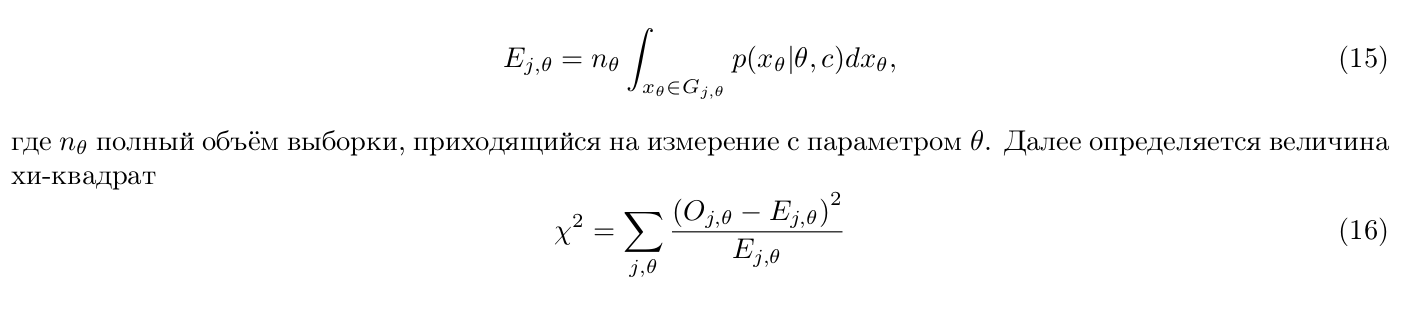

In [451]:
Image(filename='pics/Chi2.png')

In [452]:
# Разобьём данные по квантилям, чтобы в один бин не попадало менее 5-ти измерений
n_bins = 10
nt = 10000



E_list = []
O_list = []

for x, theta in zip(x_rec_list, thetas):
    x_bin_prev = x.min()
    x_bins = np.quantile(x, np.linspace(0,1,n_bins+1))
    x = np.array(sorted(x))
    for x_bin in x_bins[1:]:
        x_vals = x[(x<x_bin) & (x>x_bin_prev)]
        O = len(x_vals)
        E = nt * np.trapz(get_probs(get_theor_state(c, N, x_vals, theta)), x_vals)
        E_list.append(E)
        O_list.append(O)
        
        x_bin_prev = x_bin
        
O_list = np.array(O_list)
E_list = np.array(E_list)

Xi2 = np.sum((O_list - E_list)**2/E_list)

In [453]:
print(f'nt = {nt}')
print(f'sum(E_list) для соответствующих theta = {np.sum(np.reshape(E_list, (n_bins, 4)), axis = 0)}')

nt = 10000
sum(E_list) для соответствующих theta = [10064.18496016 10071.00079037  9807.17117845 10009.87662778]


In [454]:
nu = 4*n_bins - len(thetas) - 2*(N - 1) - 1
p_value = 1 - chi2.cdf(Xi2.real, nu)
print('p-value = ' + str(p_value))

p-value = 2.2300994631185844e-05


Для визуализации разобьём на меньшее количество бинов (n_bins = 10)

In [455]:
# Разобьём данные по квантилям, чтобы в один бин не попадало менее 5-ти измерений
n_bins = 10
nt = 10000

E_list = []
O_list = []

for x, theta in zip(x_rec_list, thetas):
    x_bin_prev = x.min()
    x_bins = np.quantile(x, np.linspace(0,1,n_bins+1))
    x = np.array(sorted(x))
    for x_bin in x_bins[1:]:
        x_vals = x[(x<x_bin) & (x>x_bin_prev)]
        O = len(x_vals)
        E = nt * np.trapz(get_probs(get_theor_state(c, N, x_vals, theta)), x_vals)
        E_list.append(E)
        O_list.append(O)
        
        x_bin_prev = x_bin
        
O_list = np.array(O_list)
E_list = np.array(E_list)

Xi2 = np.sum((O_list - E_list)**2/E_list)

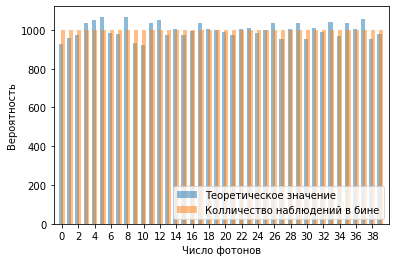

In [456]:
n_list = np.arange(E_list.shape[0])

plt.bar(n_list-0.1, E_list, alpha=0.5, width=0.5, label='Теоретическое значение')
plt.bar(n_list+0.1, O_list, alpha=0.5, width=0.5, label='Колличество наблюдений в бине')
plt.xticks(n_list[0::2])
plt.xlim(-1, E_list.shape[0])
plt.xlabel('Число фотонов')
plt.ylabel('Вероятность')
plt.legend(loc = 'lower right')
plt.show()